### Introduction

In this project we will predict the number of bikes people rented in a given hour in Washington, D.C., using and comparing the performance of three machine learning models (Linear Regression, Decision Trees and Random Forests). 

The dataset can be downloaded from the [University of California](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). It contains 17380 rows and contains the following columns:

- instant: A unique sequential ID number for each row
- dteday: The date of the rentals
- season: The season in which the rentals occurred
- yr: The year the rentals occurred
- mnth: The month the rentals occurred
- hr: The hour the rentals occurred
- holiday: Whether or not the day was a holiday
- weekday: The day of the week (as a number, 0 to 7)
- workingday: Whether or not the day was a working day
- weathersit: The weather (as a categorical variable)
- temp: The temperature, on a 0-1 scale
- atemp: The adjusted temperature
- hum: The humidity, on a 0-1 scale
- windspeed: The wind speed, on a 0-1 scale
- casual: The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- registered: The number of registered riders (people who had already signed up)
- cnt: The total number of bike rentals (casual + registered)

### Reading the data


In [1]:
import pandas as pd

bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


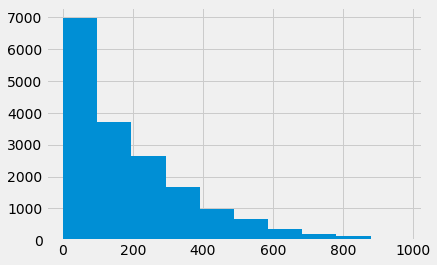

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

bike_rentals['cnt'].hist()

Looking at this histogram, we can see there's a concentration of a daily low numbers of rents (0 - 100) 

In [3]:
bike_rentals.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

Looking at the correlations, we can see that the two most correlated columns are casual and registered.This is expected, given the number we are trying to predict (cnt) are a sum of casual and registered (we will remove those columns in the next step). We will also drop the instant column, as it doesn't provides with relevant information.

Also, some columns need to be processed before applying the machine learning models, like the season (categorial variable that should be transformed into dummies). We will do those processing in the next step.

### Processing the data

In [4]:
bike_rentals.drop(columns=['instant','casual', 'registered'], axis=1, inplace=True)
bike_rentals.columns

Index(['dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

The yr and the mnth columns comes from the dteday column, so to avoid repeating information, we will remove the dteday column.

In [5]:
bike_rentals.drop(columns=['dteday'], axis=1, inplace=True)
bike_rentals.columns

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

Instead of using the hr column, we will transform this information into a new columns called time_label, that will have four possible values:

- 'Morning': Hour from 6 to 12 
- 'Afternoon': Hour from 12 to 18 
- 'Evening': Hour from 18 to 24 
- 'Night': Hour from 0 to 6

In [6]:
def convert_hr(number):
    if number >= 6 and number < 12:
        return 'Morning'
    elif number >= 12 and number < 18:
        return 'Afternoon'
    elif number >= 18 and number < 24:
        return 'Evening'
    else:
        return 'Night'

bike_rentals['time_label'] = bike_rentals['hr'].apply(convert_hr)
bike_rentals.drop(columns=['hr'], axis=1, inplace=True)
bike_rentals.head(10)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,time_label
0,1,0,1,0,6,0,1,0.24,0.2879,0.81,0.0000,16,Night
1,1,0,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40,Night
2,1,0,1,0,6,0,1,0.22,0.2727,0.80,0.0000,32,Night
3,1,0,1,0,6,0,1,0.24,0.2879,0.75,0.0000,13,Night
4,1,0,1,0,6,0,1,0.24,0.2879,0.75,0.0000,1,Night
5,1,0,1,0,6,0,2,0.24,0.2576,0.75,0.0896,1,Night
6,1,0,1,0,6,0,1,0.22,0.2727,0.80,0.0000,2,Morning
7,1,0,1,0,6,0,1,0.20,0.2576,0.86,0.0000,3,Morning
8,1,0,1,0,6,0,1,0.24,0.2879,0.75,0.0000,8,Morning
9,1,0,1,0,6,0,1,0.32,0.3485,0.76,0.0000,14,Morning


The weekday columns varies from 0 to 6 and is as numeric type. This column should be treated as categorical, so we will convert it to an object format so we can use dummies in the next steps.

The same logic can be applied to the season column (which varies from 1 to 4), the mnth column (which varies from 1 to 12) and the weathersit (varies from 1 to 4).

In [23]:
bike_rentals['weekday'] = bike_rentals['weekday'].astype('str')
bike_rentals['season'] = bike_rentals['season'].astype('str')
bike_rentals['mnth'] = bike_rentals['mnth'].astype('str')
bike_rentals['weathersit'] = bike_rentals['weathersit'].astype('str')

The remaining columns are either binary (holiday, workingday) or continuous (temp, atemp, hum and windspeed) and doesn't need to be processed further.

### Selecting features

We will test the machine learning models varying the number of features. Before doing that we need to rank those features (so we can select them by order). 

This rank will be done by using only these feature for predicting the cnt variable (using a Linear Regression) and returning the RMSE. The variables with the lowest RMSE will be ranked higher.

This RMSE will be estimated by a division in train and test (75%/25%).

In [27]:
len(bike_rentals)*0.75

13034.25

In [30]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np

target = ['cnt']
rmse_dict = {}
features = list(bike_rentals.columns)
features.remove('cnt')

for col in features:
    columns = [col, 'cnt']
     
    temp_df = pd.DataFrame(bike_rentals, copy=True)
    temp_df = temp_df[columns]
    temp_df = pd.get_dummies(temp_df)
    temp_train = temp_df[:13034]
    temp_test = temp_df[13034:]
    
    feat = list(temp_df.columns)
    feat.remove('cnt')
    
    lr = LinearRegression()
    lr.fit(temp_train[feat], temp_train[target])
    
    predictions = lr.predict(temp_test[feat])
    rmse = np.sqrt(mean_squared_error(predictions, temp_test[target]))
    
    rmse_dict[col] = rmse

In [31]:
rmse_dict

{'season': 232.75121210352867,
 'yr': 223.53608786986308,
 'mnth': 234.51080687732065,
 'holiday': 236.40297174459138,
 'weekday': 236.44810265381275,
 'workingday': 236.36761041207575,
 'weathersit': 234.98056278722729,
 'temp': 217.20263506435606,
 'atemp': 217.73071011860446,
 'hum': 225.46757823997743,
 'windspeed': 236.24843203951102,
 'time_label': 200.2709138567542}

In [32]:
variables_df = pd.DataFrame.from_dict(rmse_dict, orient='index')
variables_df['RMSE'] = variables_df[0]
variables_df = variables_df.drop(0, axis=1)
sorted_df = variables_df['RMSE'].sort_values()
sorted_df

time_label    200.270914
temp          217.202635
atemp         217.730710
yr            223.536088
hum           225.467578
season        232.751212
mnth          234.510807
weathersit    234.980563
windspeed     236.248432
workingday    236.367610
holiday       236.402972
weekday       236.448103
Name: RMSE, dtype: float64

In [34]:
features_list = list(sorted_df)
features_list

[200.2709138567542,
 217.20263506435606,
 217.73071011860446,
 223.53608786986308,
 225.46757823997743,
 232.75121210352867,
 234.51080687732065,
 234.98056278722729,
 236.24843203951102,
 236.36761041207575,
 236.40297174459138,
 236.44810265381275]

### Making predictions

In this step, we will use three models (Linear Regression, Decision Trees and Random Forests) to predict the cnt variable. Each model will be applied using from 1 to 12 variables in the order of the features_list. 

We will split the data into a training/test set (75%/25%) and we will evaluate the error by the RMSE. We will evaluate both the error by predicting the train and test set, so we can estimate the tendency to overfit (by comparing both errors).

### Linear Regression

In [37]:
from sklearn.metrics import mean_squared_error

avg_rmse_list = []
target = ['cnt']

for i in range(1, len(features_list)+1):
    features = features_list[:i]
    temp_df = pd.DataFrame(bike_rentals, copy=True)
    train = temp_df[:13034]
    test = temp_df[13034:]
    
    lr = LinearRegression()
    lr.fit(train[features], train[target])
    
    predictions = lr.predict(test[features])
    rmse = np.sqrt(mean_squared_error(predictions, test[target]))
    
    avg_rmse_list.append(rmse)

KeyError: '[200.27091386] not in index'